In [1]:
%load_ext wurlitzer

# Projecting JunoCam images
Raw *JunoCam* images consist of several framelets, each corresponding to a different filter. As the spacecraft moves, the framelets correspond to different parts of the sky. To project the raw image to a map, we need to calculate the positions of each pixel in the image. 

First, import the projector functions.

In [3]:
from projection import projector
import numpy as np
import matplotlib.pyplot as plt

The projection functions make use of the [SPICE toolkit](https://naif.jpl.nasa.gov/naif/toolkit.html) which read in kernel files that are produced by NAIF. These kernel files define the position of planets and spacecraft and are updated periodically. 

To project *JunoCam* data, we will need the Juno kernels. You can get these by using the `wget` command. Open a terminal, `cd` to the folder where you want the kernls to be, and enter the following command:
```bash
wget -m -nH --cut-dirs=3 -nv ftp://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/
```

This will create a `kernels/` folder and populate it with different kernels that define the *Juno* spacecraft and Jupiter. In the next cell, set `KERNEL_DATAFOLDER` to point to the `kernels` folder that was created. 

In [4]:
KERNEL_DATAFOLDER = '/home/local/Isis/data/juno/kernels/'

Now initialize the `Projector` class with the location of our image and metadata that's associated with it. *JunoCam* images can be downloaded from [the JunoCam Processing website](https://www.missionjuno.swri.edu/junocam/processing). To process the raw images, be sure to select the JUNOCAM filter so as to filter out user generated images. 

Click on the image, and download the images and metadata zips to this folder. Unzip them to produce the`ImageSet/` and `DataSet/` folders. Note the name of metadata file inside the `Dataset/` folder. 

We initialize the Projector class by inputting the folder containing the images (`ImageSet/`), the metadata file (`DataSet/xxxx-Metadata.json`) and the location of the kernels:

In [5]:
proj = projector.Projector("ImageSet/", "DataSet/5989-Metadata.json", KERNEL_DATAFOLDER)

Once the object is initialized, we can project it. Call the `process` method, which can run in parallel with the `num_procs` argument.

Note: This will take some time (5-10 mins), so you can go grab something to drink. 

In the end, the code will produce a netCDF4 file which contains the location of each pixel, the time/location of the spacecraft for each framelet and a illumination-geometry corrected image. The name of this file is given by the `FILE_NAME` attribute in the metadata file which can be accessed via `proj.fname`. 

In [6]:
proj.process(num_procs=10)

JNCE_2018302_16C00024_V01
Projecting framelets:
[=================== ] 97.22%
Extents - lon: 27.753 125.547 lat: -74.763 3.244 - lowest pixres: 0.008 deg/pix


The projection will determine the latitude/longitude of every pixel in the raw image. So now, we will need to combine the framelets so that we can get a 'map-projected' image. Ideally this should be in one of the [standard cartographic projections](https://en.wikipedia.org/wiki/List_of_map_projections#pseudocylindrical) but, for now, we'll just use a lon/lat grid.

To project the map, we need to define our grid. The `proj` object defined above calculates the extent of the image. These can be determined from the object attributes (`lonmin`, `lonmax`, `latmin`, `latmax`) and we can create a uniform spacing between them. 

Once these are created, we call the `map_project` function and use the input the newly generated netCDF4 file. This code can be parallelized with the `num_procs` option as before, and use `save=True` if you want to save the RGB frames to a PNG file and the mosaic to a netCDF4 file (`filename`_proj.nc where `filename` is the `proj.fname` attribute as before). 

In [7]:
resolution=50 ## pixels/degree
newlon = np.arange(proj.lonmin, proj.lonmax, 1./resolution)
newlat = np.arange(proj.latmin, proj.latmax, 1./resolution)
print("Mosaic size: %d x %d"%(newlon.size, newlat.size))
IMG, mask = projector.map_project(newlon, newlat, "%s.nc"%proj.fname, save=True, num_procs=10)

Mosaic size: 4890 x 3901
Projecting JNCE_2018302_16C00024_V01
Processing R
 3900/3901 
[=================== ] 98.68%
Processing G
 3900/3901 
[=================== ] 98.70%
Processing B
 3900/3901 
[=================== ] 98.70%


Finally, we do a basic color correction, normalization and gamma correction to the image. Input the latitude/longitude from before for setting the axis. 

You can save out the new image to a PNG file (with filename given by the `fname` argument) with `save=True`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


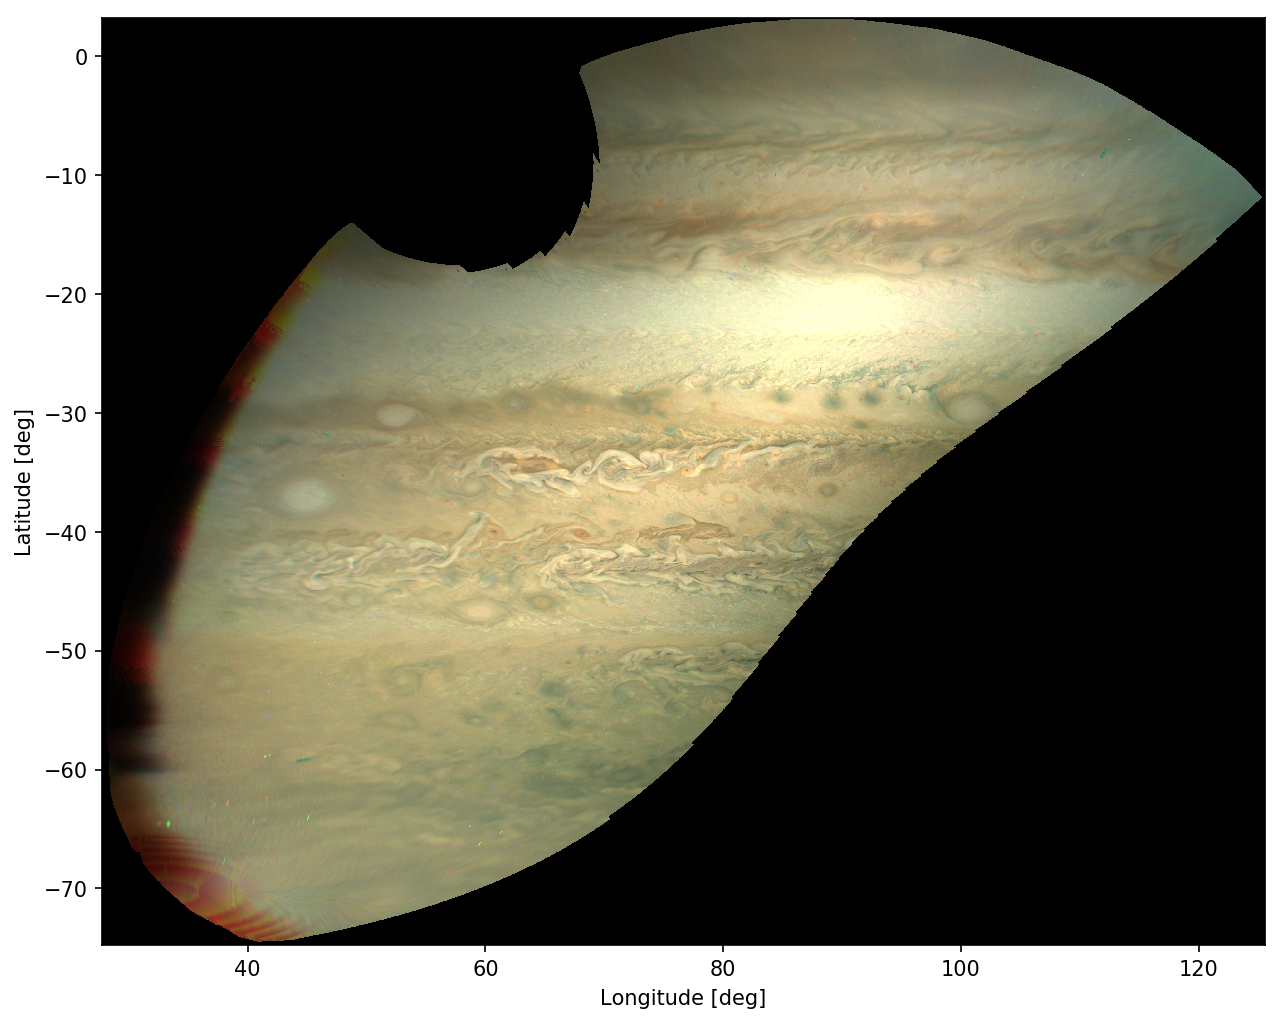

In [8]:
IMG_corr = projector.color_correction(IMG, newlon, newlat, gamma=1.5, fname=proj.fname, save=True)